# 机器人自动走迷宫-程序报告

吴天宇 12334125


# 1 实验概要

## 1.1 实验内容  
在本实验中，要求分别使用基础搜索算法和 Deep QLearning 算法，完成机器人自动走迷宫。
 
<img src="https://imgbed.momodel.cn/20200914145238.png"/>

如上图所示，左上角的红色椭圆既是起点也是机器人的初始位置，右下角的绿色方块是出口。          
游戏规则为：从起点开始，通过错综复杂的迷宫，到达目标点(出口)。
        
+ 在任一位置可执行动作包括：向上走 `'u'`、向右走 `'r'`、向下走 `'d'`、向左走 `'l'`。

+ 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞墙
    - 走到出口
    - 其余情况
    
    
+ 需要您分别实现**基于基础搜索算法**和 **Deep QLearning 算法**的机器人，使机器人自动走到迷宫的出口。

# 2 基于最佳优先搜索 A* 算法

本实验旨在使用A*搜索算法，编程实现机器人在迷宫中自动寻找从起点到终点的最短路径。以下是详细的代码实现和解释。

2.1 导入必要的库和模块

In [10]:
import os
import random
import numpy as np
from Maze import Maze  # 迷宫环境类
from Runner import Runner
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot  # PyTorch版本的机器人
#from keras_py.MinDQNRobot import MinDQNRobot as KerasRobot  # Keras版本的机器人
import matplotlib.pyplot as plt

2.2 定义移动方向字典

move_map 是一个字典，用于将动作（‘u’、‘r’、‘d’、‘l’）映射到相应的坐标变化，可以根据动作更新机器人在迷宫中的位置。

In [3]:
# ==================== 移动方向字典 ====================
move_map = {
    'u': (-1, 0),  # 向上移动，行坐标减1，列坐标不变
    'r': (0, 1),   # 向右移动，行坐标不变，列坐标加1
    'd': (1, 0),   # 向下移动，行坐标加1，列坐标不变
    'l': (0, -1)   # 向左移动，行坐标不变，列坐标减1
}

2.3 定义搜索树节点类

 + SearchTree 类表示搜索树中的一个节点，包含了位置、动作、父节点、子节点、实际代价 g 和评估函数值 f 等属性。

 + loc：节点在迷宫中的位置坐标。

 + to_this_action：从父节点到达当前节点所采取的动作。

 + parent：父节点对象。

 + children：子节点列表。

 + g：从起点到当前节点的实际代价，即路径长度。

 + f：评估函数值，f = g + h，其中 h 是启发式函数的估计代价。

 + add_child(child) 方法用于向当前节点添加子节点。

 + is_leaf() 方法用于判断当前节点是否为叶子节点（没有子节点）。

In [4]:
# ==================== 搜索树节点类 ====================
class SearchTree:
    def __init__(self, loc=(), action='', parent=None):
        """
        初始化搜索树节点对象。
        
        参数:
            loc (tuple): 当前节点的位置坐标 (x, y)。
            action (str): 到达该节点的动作（'u', 'r', 'd', 'l'）。
            parent (SearchTree): 该节点的父节点。
        """
        self.loc = loc                 # 当前节点的位置
        self.to_this_action = action   # 到达该节点的动作
        self.parent = parent           # 父节点
        self.children = []             # 子节点列表
        self.g = 0                     # 从起点到当前节点的实际代价（路径长度）
        self.f = 0                     # 启发式估值 f = g + h

    def add_child(self, child):
        """
        添加子节点。
        
        参数:
            child (SearchTree): 待添加的子节点。
        """
        self.children.append(child)

    def is_leaf(self):
        """
        判断当前节点是否是叶子节点（没有子节点）。
        
        返回:
            bool: 如果没有子节点，则返回 True。
        """
        return len(self.children) == 0

2.4 定义启发式函数

 + heuristic_manhattan 函数计算当前节点位置 curr 到目标节点位置 goal 的曼哈顿距离，用作启发式估计。

 + 曼哈顿距离是指在格子地图中，只能沿着水平方向和竖直方向移动时，从一个点到另一个点的最短路径长度。

In [5]:
# ==================== 启发式函数 ====================
def heuristic_manhattan(curr, goal):
    """
    计算当前位置到目标点的曼哈顿距离。
    
    参数:
        curr (tuple): 当前坐标 (x, y)。
        goal (tuple): 目标坐标 (x, y)。
    
    返回:
        int: 曼哈顿距离。
    """
    return abs(curr[0] - goal[0]) + abs(curr[1] - goal[1])

2.5 定义节点扩展函数

  + expand_a_star 函数用于扩展当前节点的所有可行子节点。

  + 首先获取当前节点可以采取的有效动作 valid_actions，即从当前位置可以移动到哪些方向而不撞墙。

  + 对于每一个有效动作，计算新的位置 new_loc。

  + 如果新的位置没有被访问过（不在 closed_set 中），则：

    + 计算从起点到新节点的实际代价 g_new，即当前节点的 g 值加1。

    + 使用启发式函数计算新节点到目标的估计代价 h_new。

    + 计算评估函数值 f_new = g_new + h_new。

    + 创建新节点 child，设置其位置、动作、父节点、g 值和 f 值。

    + 将新节点添加到开放列表 open_list 中，等待后续的扩展。

In [6]:
# ==================== 节点扩展函数 ====================
def expand_a_star(maze, closed_set, node, goal, open_list):
    """
    扩展当前节点的所有可行子节点，并将新节点加入 open_list。
    
    参数:
        maze (Maze): 迷宫对象。
        closed_set (set): 已访问节点的集合，防止重复搜索。
        node (SearchTree): 当前待扩展的节点。
        goal (tuple): 目标点坐标。
        open_list (list): 存放待扩展节点的开放列表。
    """
    # 获取从当前节点可以采取的有效动作
    valid_actions = maze.can_move_actions(node.loc)
    for a in valid_actions:
        # 计算新节点的位置
        new_loc = tuple(node.loc[i] + move_map[a][i] for i in range(2))
        
        # 如果新位置没有被访问过，将其添加到 open_list
        if new_loc not in closed_set:
            g_new = node.g + 1  # 更新 g 值（从起点到新节点的实际代价）
            h_new = heuristic_manhattan(new_loc, goal)  # 计算启发式估计 h 值
            f_new = g_new + h_new  # 评估函数 f = g + h

            # 创建新节点并设置 g 和 f 值
            child = SearchTree(loc=new_loc, action=a, parent=node)
            child.g = g_new
            child.f = f_new

            # 将新节点加入开放列表
            open_list.append(child)

2.6 定义路径回溯函数

  + back_propagation_a_star 函数用于从目标节点开始，沿着父节点指针回溯到起点，构建从起点到目标点的动作序列。

  + path 列表用于存储动作序列。

  + 在循环中，将每个节点的 to_this_action 插入到 path 的开头，实现路径的正序。

  + 当 node.parent 为 None 时，说明已经回溯到起点，结束循环。

In [7]:
# ==================== 路径回溯函数 ====================
def back_propagation_a_star(node):
    """
    回溯路径，从目标节点回溯到起始节点，生成路径列表。
    
    参数:
        node (SearchTree): 目标节点。
    
    返回:
        list: 从起点到目标点的路径（动作序列）。
    """
    path = []
    while node.parent is not None:
        path.insert(0, node.to_this_action)  # 在路径开头插入动作
        node = node.parent  # 回溯到父节点
    return path

2.7 定义 A* 搜索算法

 + my_search 函数实现了 A* 搜索算法。

 + 初始化起点 start 和目标点 goal。

 + 创建起点节点 root，设置其 g 值为 0，f 值为启发式估计值。

 + 初始化开放列表 open_list 和已访问节点集合 closed_set。

 + 在主循环中，执行以下步骤：

   + 从开放列表中选择 f 值最小的节点 current_node，并将其从开放列表中移除。

   + 如果当前节点就是目标节点，则调用 back_propagation_a_star 函数回溯路径，返回动作序列。

   + 将当前节点的位置添加到已访问集合 closed_set 中。

   + 扩展当前节点，生成其子节点，并将新的子节点添加到开放列表中。

   + 如果开放列表为空但未找到目标节点，则返回空列表，表示无解。

In [8]:
# ==================== A*搜索算法 ====================
def my_search(maze):
    """
    使用 A* 算法在迷宫中搜索从起点到终点的最短路径。
    
    参数:
        maze (Maze): 待搜索的迷宫对象。
    
    返回:
        list: 最优路径上的动作序列（如果未找到路径，则返回空列表）。
    """
    # 初始化起点和目标点
    start = maze.sense_robot()
    goal = maze.destination
    
    # 初始化起点节点并设置初始 g 值和 f 值
    root = SearchTree(loc=start)
    root.g = 0  # 起点的 g 值为 0
    root.f = heuristic_manhattan(start, goal)  # 计算起点的 f 值

    # 创建开放列表和已访问节点集合
    open_list = [root]
    closed_set = set()

    # 主循环：每次从 open_list 中选取 f 值最小的节点进行扩展
    while open_list:
        # 找到 f 值最小的节点并将其从 open_list 中移除
        current_node = min(open_list, key=lambda x: x.f)
        open_list.remove(current_node)

        # 如果当前节点是目标点，回溯路径
        if current_node.loc == goal:
            return back_propagation_a_star(current_node)

        # 将当前节点的位置添加到 closed_set 中，表示该节点已访问
        closed_set.add(current_node.loc)

        # 扩展当前节点的所有子节点，并将有效子节点加入 open_list
        expand_a_star(maze, closed_set, current_node, goal, open_list)

    # 如果开放列表为空且未找到路径，返回空列表
    return []

2.8 测试搜索算法

 + 创建一个 10x10 的迷宫 maze。

 + 调用 my_search(maze) 函数，使用 A* 算法搜索从起点到终点的最优路径，返回动作序列 path_2。

 + 打印搜索到的路径。

 + 让机器人按照搜索到的动作序列移动，通过 maze.move_robot(action) 执行动作。

 + 检查机器人当前的位置是否等于目标位置，如果是，则打印“恭喜你，到达了目标点”。

 + 打印迷宫的当前状态，包括机器人的位置和路径。

搜索出的路径： ['d', 'd', 'r', 'd', 'r', 'd', 'r', 'r', 'd', 'r', 'd', 'r', 'd', 'd', 'r', 'r', 'd', 'r']
恭喜你，到达了目标点


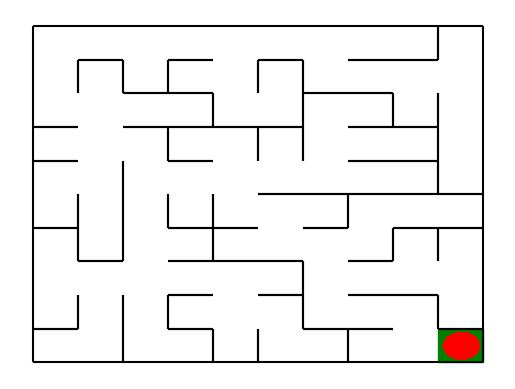

Maze of size (10, 10)


In [9]:
# ==================== 测试搜索算法 ====================
# 初始化迷宫，设置迷宫大小为10x10
maze = Maze(maze_size=10)  # 从文件或预设生成迷宫对象

# 使用 A* 搜索算法在迷宫中寻找从起点到终点的最短路径
path_2 = my_search(maze)
print("搜索出的路径：", path_2)  # 打印搜索到的路径（动作序列）

# 根据 A* 算法返回的路径依次移动机器人
for action in path_2:
    maze.move_robot(action)  # 执行动作，将机器人在迷宫中移动

# 检查机器人是否到达目标位置
if maze.sense_robot() == maze.destination:
    print("恭喜你，到达了目标点")  # 打印成功信息

# 输出当前迷宫的状态，包括机器人的位置和路径
print(maze)